# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [2]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster1"
p_codes = cluster_dict['cluster1']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
# log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Recipe Origin 
recipe_origin_df = recipe_df.copy()

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [3]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [4]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 13)


In [5]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [6]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 34)


In [8]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type='CMB')  
# dataset = dataset.drop(columns=['Cluster'])

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (19156, 35)


In [9]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch (T3)_결과", "Scorch (T5)_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time        19040
Ct 90_결과             12
M/B_결과             7238
M/B_기준             6479
Scorch (T3)_결과        0
Scorch (T5)_결과        0
Vm_결과                 0
경도_결과                 0
dtype: int64


## ***PLOT***
---

In [130]:
### 시각화 
# Apply 
product_code = 'FFHED60009' 
# plot_cluster(log_df, product_code) 

## ***점도별 제품 코드 분할***
---

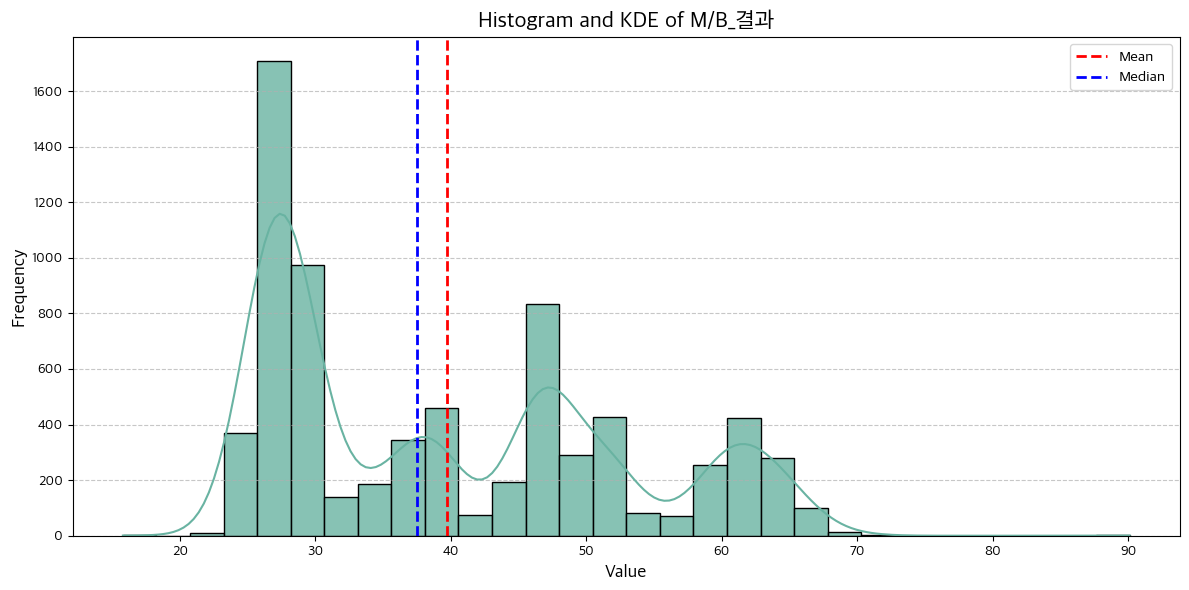

In [10]:
### Target 분포 확인
temp_col = 'M/B_결과'

# 분포 Plot 
feature_normal_distribution(dataset, feature=temp_col) 

In [ ]:
### Vm Clustering 
# Apply 
temp_dataset = cluster_vm(dataset, target_col='Vm_결과') 

# 각 Cluster별 제품코드 조회 
cluster_1_vm,cluster_2_vm,cluster_3_vm,cluster_4_vm = [],[],[],[]
temp_dataset['제품코드'] = temp_dataset['작업지시번호-배치'].map(lambda x: x[6:16]) 
for idx, row in temp_dataset.iterrows(): 
    # P_code 
    p_code = row['제품코드'] 

    # Append 
    if row['Cluster_Vm']==1:
        cluster_1_vm.append(p_code)  
    elif row['Cluster_Vm']==2: 
        cluster_2_vm.append(p_code)  
    elif row['Cluster_Vm']==3: 
        cluster_3_vm.append(p_code)  
    elif row['Cluster_Vm']==4: 
        cluster_4_vm.append(p_code)   
    else: 
        print(f'Cluster 안에 na 확인 {row["작업지시번호-배치"]}') 

# 리스트 중복 제거 (set → list)
cluster_1_vm = list(set(cluster_1_vm))
cluster_2_vm = list(set(cluster_2_vm))
cluster_3_vm = list(set(cluster_3_vm))
cluster_4_vm = list(set(cluster_4_vm))

# 결과 확인
print(f"Cluster 1 제품코드 수: {len(cluster_1_vm)}")
print(f"Cluster 2 제품코드 수: {len(cluster_2_vm)}")
print(f"Cluster 3 제품코드 수: {len(cluster_3_vm)}")
print(f"Cluster 4 제품코드 수: {len(cluster_4_vm)}")

Cluster 1 제품코드 수: 5
Cluster 2 제품코드 수: 14
Cluster 3 제품코드 수: 18
Cluster 4 제품코드 수: 6


In [ ]:
### 모든 제품코드 기준 결과값 Median 산출 
summary = target_median(dataset, target_col='Vm_결과')
summary

,제품코드,Vm_결과_median,Vm_결과_n
0,FFHED60009,24.816,2126
1,FFWES60194,40.300,1140
2,FFSED70533,40.300,1950
3,FFWED70199,41.000,247
4,FFWED70007,41.500,2286
5,FFWED70103,42.200,691
6,FFHED60006,42.944,1006
7,FFWED70033,43.100,641
8,FFWED70284,44.800,2968
9,FFHED70147,45.760,4076


In [128]:
# Apply 
summary = target_median(dataset, target_col='경도_결과')
summary

,제품코드,경도_결과_median,경도_결과_n
0,FFHED60009,59.50,5641
1,FFHED60006,70.80,690
2,FFWED70103,72.00,110
3,FFHED70076,73.90,3373
4,FFHED70014,73.95,66
5,FFWED70007,74.00,3323
6,FFHED70147,74.00,5747
7,FFSED70533,74.20,1776
8,FFSED70438,74.70,595
9,FFWED70033,75.00,114
